In [5]:
import numpy as np
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt

In [67]:
def read_M(s):
    M = []
    for l in s[:-1].split('\n'):
        M.append(list(l))
    return np.array(M)
    
def padding(M):
    i = M.shape[0] + 2
    j = M.shape[1] + 2
    M_new = np.zeros(shape=(i, j))
    M_new[1:-1, 1:-1] = M.copy()
    return M_new        

In [252]:
def apply_convolution(input_array, filter_kernel):
    """
    Applies a convolution on the input array using the given filter kernel.
    
    Args:
    input_array (torch.Tensor): The input 2D array with shape (H, W).
    filter_kernel (torch.Tensor): The 2D filter kernel with shape (kH, kW).
    
    Returns:
    torch.Tensor: The result of the convolution operation.
    """
    # Ensure the input array is a 4D tensor with shape (1, 1, H, W)
    input_tensor = torch.from_numpy(input_array).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    
    # Ensure the filter kernel is a 4D tensor with shape (1, 1, kH, kW)
    kernel_tensor = torch.from_numpy(filter_kernel).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, kH, kW)
    
    # Perform the 2D convolution
    output_tensor = F.conv2d(input_tensor, kernel_tensor, padding=(
        (filter_kernel.shape[0] - 1) // 2,
        (filter_kernel.shape[1] - 1) // 2
    )
    )
    
    # Remove the batch and channel dimensions to return a simple 2D array
    output_array = output_tensor.squeeze(0).squeeze(0)  # Shape: (H_out, W_out)
    
    return output_array.numpy()

kernel_fil = np.array(
    [[0, 1, 0],
     [1, 1, 1],
     [0, 1, 0]]
).astype(float)

kernel_neighbour = np.array(
    [[0, 1, 0],
     [1, 0, 1],
     [0, 1, 0]]
).astype(float)

kernel_horizontal_up = np.array(
    [[-1],
    [1],
    [0]]
).astype(float)

kernel_horizontal_down = np.array(
    [[0],
    [1],
    [-1]]
).astype(float)

kernel_vertical_left = np.array(
    [[-1, 1, 0]]
).astype(float)

kernel_vertical_right = np.array(
    [[0, 1, -1]]
).astype(float)

In [139]:
def get_values_for_one_object(M, start, kernel_fil, kernel_neighbour):
    plant = M[start]
    M_fil = M.copy()
    M_fil_prev = M.copy()
    M_fil[start] = '1'
    while (M_fil != M_fil_prev).sum()!=0:
        M_current = (M_fil == '1').astype(float)
        M_neighbours = apply_convolution(M_current, kernel_fil) > 0
        M_same = (M == plant)
        M_fil_prev = M_fil.copy()
        M_fil[M_neighbours&M_same] = '1'
    M_current = (M_fil == '1').astype(float)
    area = int(M_current.sum())
    M_edge = apply_convolution(M_current, kernel_neighbour)
    perimeter = int(((4 - (M_edge * M_current)) * M_current).sum())
    fil = M_fil == '1'
    M_new = M.copy()
    M_new[fil] = '0'
    return area * perimeter, M_new

In [149]:
def get_values(M, kernel_fil, kernel_neighbour):
    A = []
    for i in range(M.shape[0]):
        A.append(['0' for x in range(M.shape[1])])
    A = np.array(A)
    scores = 0
    while (M != A).sum() > 0:
        start = np.where(M != '0')
        start = start[0][0], start[1][0]
        s, M = get_values_for_one_object(M, start, kernel_fil, kernel_neighbour)
        scores += s
    return scores

In [224]:
s = 'RRRRIICCFF\nRRRRIICCCF\nVVRRRCCFFF\nVVRCCCJFFF\nVVVVCJJCFE\nVVIVCCJJEE\nVVIIICJJEE\nMIIIIIJJEE\nMIIISIJEEE\nMMMISSJEEE\n'
M = read_M(s)
get_values(M, kernel_fil, kernel_neighbour)

1930

In [225]:
with open('../data/d12.txt') as fin:
    s = fin.read()
M = read_M(s)
get_values(M, kernel_fil, kernel_neighbour)

1465112

In [277]:
def get_values_for_one_object2(M, start, kernel_fil, kernel_neighbour):
    plant = M[start]
    M_fil = M.copy()
    M_fil_prev = M.copy()
    M_fil[start] = '1'
    while (M_fil != M_fil_prev).sum()!=0:
        M_current = (M_fil == '1').astype(float)
        M_neighbours = apply_convolution(M_current, kernel_fil) > 0
        M_same = (M == plant)
        M_fil_prev = M_fil.copy()
        M_fil[M_neighbours&M_same] = '1'
    M_current = (M_fil == '1').astype(float)
    area = int(M_current.sum())
    M_edge = apply_convolution(M_current, kernel_neighbour)
    sides = get_sides(M_current, kernel_horizontal_down, kernel_horizontal_up, kernel_vertical_left, kernel_vertical_right)
    fil = M_fil == '1'
    M_new = M.copy()
    M_new[fil] = '0'
    return area * sides, M_new

In [278]:
def get_values2(M, kernel_fil, kernel_neighbour):
    A = []
    for i in range(M.shape[0]):
        A.append(['0' for x in range(M.shape[1])])
    A = np.array(A)
    scores = 0
    while (M != A).sum() > 0:
        start = np.where(M != '0')
        start = start[0][0], start[1][0]
        s, M = get_values_for_one_object2(M, start, kernel_fil, kernel_neighbour)
        scores += s
    return scores

In [279]:
s = 'RRRRIICCFF\nRRRRIICCCF\nVVRRRCCFFF\nVVRCCCJFFF\nVVVVCJJCFE\nVVIVCCJJEE\nVVIIICJJEE\nMIIIIIJJEE\nMIIISIJEEE\nMMMISSJEEE\n'
M = read_M(s)
get_values2(M, kernel_fil, kernel_neighbour)

1206

In [280]:
with open('../data/d12.txt') as fin:
    s = fin.read()
M = read_M(s)
get_values2(M, kernel_fil, kernel_neighbour)

893790

In [253]:
M_current = (M_fil == '1').astype(float)
M_hor1 = apply_convolution(M_current, kernel_horizontal_down) * M_current
M_hor2 = apply_convolution(M_current, kernel_horizontal_up) * M_current
M_ver1 = apply_convolution(M_current, kernel_vertical_left) * M_current
M_ver2 = apply_convolution(M_current, kernel_vertical_right) * M_current

In [276]:
def get_sides(M_current, kernel_horizontal_down, kernel_horizontal_up, kernel_vertical_left, kernel_vertical_right):
    M_hor1 = apply_convolution(M_current, kernel_horizontal_down) * M_current
    M_hor2 = apply_convolution(M_current, kernel_horizontal_up) * M_current
    M_ver1 = apply_convolution(M_current, kernel_vertical_left) * M_current
    M_ver2 = apply_convolution(M_current, kernel_vertical_right) * M_current
    sides = 0
    for i in range(M_hor1.shape[0]):
        current = 0
        for j in range(M_hor1.shape[1]):
            if (current==0) & (M_hor1[i, j]==1):
                sides+=1
            current = M_hor1[i, j]
    for i in range(M_hor2.shape[0]):
        current = 0
        for j in range(M_hor2.shape[1]):
            if (current==0) & (M_hor2[i, j]==1):
                sides+=1
            current = M_hor2[i, j]
    for j in range(M_ver1.shape[1]):
        current = 0
        for i in range(M_ver1.shape[0]):
            if (current==0) & (M_ver1[i, j]==1):
                sides+=1
            current = M_ver1[i, j]
    
    for j in range(M_ver2.shape[1]):
        current = 0
        for i in range(M_ver2.shape[0]):
            if (current==0) & (M_ver2[i, j]==1):
                sides+=1
            current = M_ver2[i, j]
    return sides

In [275]:
sides

10

In [167]:
X = (4 - (M_edge * M_current)) * M_current

In [169]:
np.where(X == X.max())

(array([2, 3]), array([4, 2]))

In [265]:
M_hor2

array([[ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [94]:
kernel = np.array(
    [[0, 1, 0],
     [1, 1, 1],
     [0, 1, 0]]
).astype(float)

In [104]:
kernel_neighbour = np.array(
    [[0, 1, 0],
     [1, 0, 1],
     [0, 1, 0]]
).astype(float)

In [65]:
M_neighbours

array([['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['0', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0'],
       ['0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.

In [53]:
input_array = M_current.copy()
filter_kernel = kernel.copy()
input_tensor = torch.from_numpy(input_array).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    
    # Ensure the filter kernel is a 4D tensor with shape (1, 1, kH, kW)
kernel_tensor = torch.from_numpy(filter_kernel).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, kH, kW)
output_tensor = F.conv2d(input_tensor, kernel_tensor)

In [57]:
output_tensor

tensor([[[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=torch.float64)

In [14]:
def find_object(M, start):
    plant = M[start]
    M_fil = M.copy()
    
    

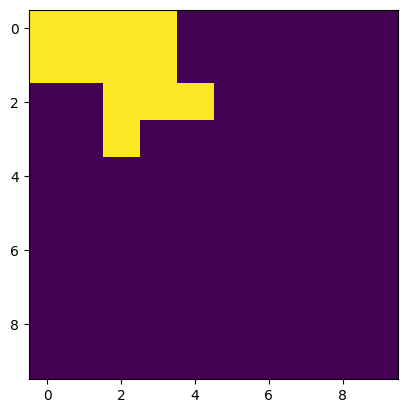

In [13]:
plt.imshow((M == 'R'))

In [2]:
import torch
import torch.nn.functional as F

def apply_convolution(input_array, filter_kernel):
    """
    Applies a convolution on the input array using the given filter kernel.
    
    Args:
    input_array (torch.Tensor): The input 2D array with shape (H, W).
    filter_kernel (torch.Tensor): The 2D filter kernel with shape (kH, kW).
    
    Returns:
    torch.Tensor: The result of the convolution operation.
    """
    # Ensure the input array is a 4D tensor with shape (1, 1, H, W)
    input_tensor = input_array.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    
    # Ensure the filter kernel is a 4D tensor with shape (1, 1, kH, kW)
    kernel_tensor = filter_kernel.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, kH, kW)
    
    # Perform the 2D convolution
    output_tensor = F.conv2d(input_tensor, kernel_tensor)
    
    # Remove the batch and channel dimensions to return a simple 2D array
    output_array = output_tensor.squeeze(0).squeeze(0)  # Shape: (H_out, W_out)
    
    return output_array

# Example usage
if __name__ == "__main__":
    # Create a simple 2D input array (image)
    input_array = torch.tensor([[1.0, 2.0, 3.0],
                                [4.0, 5.0, 6.0],
                                [7.0, 8.0, 9.0]])
    
    # Create a simple 2D filter kernel (like an edge-detection kernel)
    filter_kernel = torch.tensor([[1.0, 0.0, -1.0],
                                  [1.0, 0.0, -1.0],
                                  [1.0, 0.0, -1.0]])
    
    # Run the convolution
    output = apply_convolution(input_array, filter_kernel)
    
    print("Input Array:")
    print(input_array)
    print("\nFilter Kernel:")
    print(filter_kernel)
    print("\nConvolution Output:")
    print(output)


Input Array:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Filter Kernel:
tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

Convolution Output:
tensor([[-6.]])
